<a href="https://colab.research.google.com/github/ryanmdpeters21/Data-Analysis/blob/main/Football_Analytics_with_Python_chap2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install pandas
# !pip install numpy
!pip install nfl_data_py

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.7 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13187 sha256=f01327eefc7c61d8c92de278261728d9844eae10f270ee5b7225f850763119fd
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py


In [2]:
# Our hypothesis is that throwing deep passes is more valuable than throwing short passes.
# We need to define what 'valuable' is in this case. We use data.

In [3]:
!pip install nfl_data_py

In [4]:
# Import packages

import pandas as pd
import numpy as np
import nfl_data_py as nfl

In [5]:
# Load in our data using .import_pbp_data

seasons = range(2016, 2022 + 1)
pbp_py = nfl.import_pbp_data(seasons)

2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [6]:
# We can filter down our play-by-play dataset to just include passing plays.
pbp_py_p = pbp_py.query("play_type == 'pass' & air_yards.notnull()").reset_index()

In [7]:
# First we want to define what are long and short passes. In this case long = 20+ yards, and short = 0-20 yards.
# We use np.where() to filter.
pbp_py_p['pass_length_air_yards'] = np.where(
    pbp_py_p['air_yards'] >= 20, 'long', 'short'
)

# Now we can use the filtering criteria to replace missing values.
pbp_py_p['passing_yards'] = \
    np.where(
        pbp_py_p['passing_yards'].isnull(), 0, pbp_py_p['passing_yards']
)

In [8]:
# We can look at some basic statistics using the .describe function
pbp_py_p['passing_yards']\
  .describe()

count    131606.000000
mean          7.192111
std           9.667021
min         -20.000000
25%           0.000000
50%           5.000000
75%          11.000000
max          98.000000
Name: passing_yards, dtype: float64

In [9]:
# We can select for short passes.
pbp_py_p\
  .query('pass_length_air_yards == "short"')['passing_yards']\
  .describe()

count    116087.000000
mean          6.526812
std           7.697057
min         -20.000000
25%           0.000000
50%           5.000000
75%          10.000000
max          95.000000
Name: passing_yards, dtype: float64

In [10]:
# We can select for long passes.
pbp_py_p\
  .query('pass_length_air_yards == "long"')['passing_yards']\
  .describe()

count    15519.000000
mean        12.168761
std         17.923950
min          0.000000
25%          0.000000
50%          0.000000
75%         26.000000
max         98.000000
Name: passing_yards, dtype: float64

In [11]:
# We can now perform the same analysis on EPA (Expected Points Added).
# EPA is a measure of play success based on situational factors.
pbp_py_p\
  .query('pass_length_air_yards == "short"')['epa']\
  .describe()

count    116086.000000
mean          0.119606
std           1.426238
min         -13.031219
25%          -0.606135
50%          -0.002100
75%           0.959107
max           8.241420
Name: epa, dtype: float64

In [12]:
# We can do the same thing for long passes now.
pbp_py_p\
  .query('pass_length_air_yards == "long"')['epa']\
  .describe()

count    15519.000000
mean         0.382649
std          2.185551
min        -10.477921
25%         -0.827421
50%         -0.465344
75%          2.136431
max          8.789743
Name: epa, dtype: float64

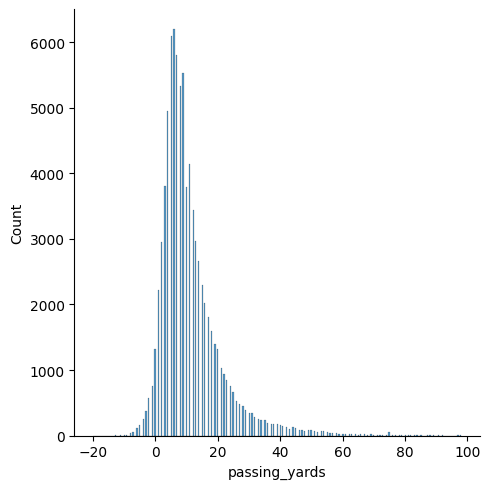

In [13]:
# Now we want to work with plotting our data.
# First we want to install our plotting packages: seaborn and matplotlib.
import seaborn as sns
import matplotlib.pyplot as plt

# We will use .displot() to create a bar graph for passing yards.
sns.displot(data=pbp_py, x='passing_yards');
plt.show();

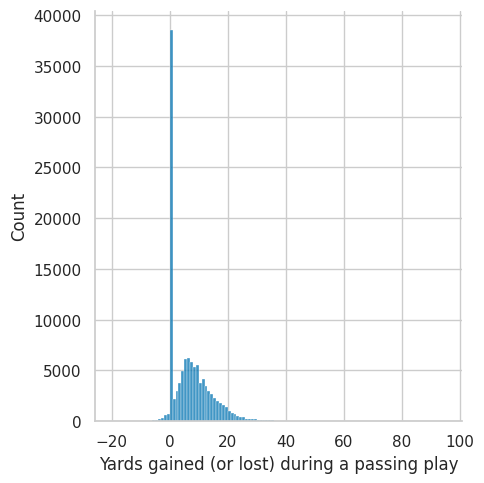

In [14]:
# Let's make a histogram for 'short' passes.
sns.set_theme(style='whitegrid', palette='colorblind')

pbp_py_p_short = \
  pbp_py_p\
  .query('pass_length_air_yards == "short"')

pbp_py_hist_short = \
  sns.displot(data=pbp_py_p_short,
              binwidth=1,
              x='passing_yards');

pbp_py_hist_short.set_axis_labels(
      "Yards gained (or lost) during a passing play", "Count"
  );
plt.show();

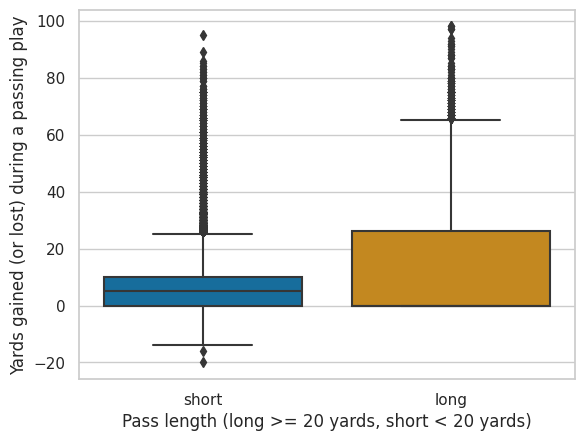

In [15]:
# Let's make a boxplot for both long and short passes.
# Box plots are used to show variability and outliers in data.
pass_boxplot = \
  sns.boxplot(data=pbp_py_p,
              x='pass_length_air_yards',
              y='passing_yards');
pass_boxplot.set(
    xlabel='Pass length (long >= 20 yards, short < 20 yards)',
    ylabel='Yards gained (or lost) during a passing play',
);
plt.show();

In [16]:
# Let's start analyzing player data. For this we will want season-level data.
# To do this, let's start by aggregating at the season level using .groupby().
# We will group by passer_player_name, passer_player_id, season and pass_length.
pbp_py_p_s = \
  pbp_py_p\
  .groupby(['passer_id', 'passer', 'season'])\
  .agg({'passing_yards': ['mean', 'count']})

pbp_py_p_s.columns = list(map('_'.join, pbp_py_p_s.columns.values))

pbp_py_p_s \
  .rename(columns={'passing_yards_mean': 'ypa',
                   'passing_yards_count': 'n'},
          inplace=True)

pbp_py_p_s\
  .sort_values(by=['ypa'], ascending=False)\
  .head()

,,,ypa,n
passer_id,passer,season,,
00-0035544,T.Kennedy,2021,75.0,1
00-0033132,K.Byard,2018,66.0,1
00-0031235,O.Beckham,2018,53.0,2
00-0030669,A.Wilson,2018,52.0,1
00-0029632,M.Sanu,2017,51.0,1


In [17]:
# We can see above that most of the players at the top of the list have a very small sample size.
# Let's redo it, but only allow for players with over 100 pass attempts in a single season.
pbp_py_p_s_100 = \
  pbp_py_p_s\
  .query('n >= 100')\
  .sort_values(by=['ypa'], ascending=False)

pbp_py_p_s_100.head()

,,,ypa,n
passer_id,passer,season,,
00-0023682,R.Fitzpatrick,2018,9.617887,246
00-0026143,M.Ryan,2016,9.442155,631
00-0029701,R.Tannehill,2019,9.069971,343
00-0033537,D.Watson,2020,8.898524,542
00-0036212,T.Tagovailoa,2022,8.892231,399


In [20]:
# Now we want to test our original hypothesis.
  # Calculate the YPA for each passer for each season
  # Calculate the YPA for each passer for the previous season.
  # Look at the correlation from the values calculated in steps 1 and 2 to see the stability.
# We will use _p for passing plays, _s for seasons data, and _pl for pass length
# Let's start by creating our first variable.
pbp_py_p_s_pl = \
  pbp_py_p\
  .groupby(['passer_id', 'passer', 'season', 'pass_length_air_yards'])\
  .agg({'passing_yards': ['mean', 'count']})

In [21]:
# Let's shorten the names of our columns so they are easier to work with
# We'll change passing_yards_mean to ypa and passing_yards_count to n
pbp_py_p_s_pl.columns =\
  list(map("_".join, pbp_py_p_s_pl.columns.values))
pbp_py_p_s_pl\
  .rename(columns={'passing_yards_mean': 'ypa',
                    'passing_yards_count': 'n'},
          inplace=True)
# Now we must reset the index
pbp_py_p_s_pl.reset_index(inplace=True)

In [22]:
# Now let's select only short-passing data from players with >100 plays
# We will select only long-passing data from players with >30 plays
q_value = (
    '(n >= 100 & ' +
    'pass_length_air_yards == "short") | ' +
    '(n >= 30 & ' +
    'pass_length_air_yards == "long")'
)
pbp_py_p_s_pl = pbp_py_p_s_pl.query(q_value).reset_index()

In [23]:
# Now we can create a list of columns and new df with only these columns
# We include .copy() so that edits are not passed back to the original df
cols_save =\
  ['passer_id', 'passer', 'season',
   'pass_length_air_yards', 'ypa']
air_yards_py =\
  pbp_py_p_s_pl[cols_save].copy()

In [24]:
# Next we can copy air_yards_py to create air_yards_lag_py.
# We take the current season value and add 1 by using +=
# We rename passing_yards_mean to include lag
air_yards_lag_py = air_yards_py.copy()
air_yards_lag_py['season'] += 1
air_yards_lag_py\
  .rename(columns={'ypa': 'ypa_last'},
          inplace=True)

In [25]:
# Now we can merge the two df's together to create air_yards_both_py.
# We use an inner join so only shared years are saved and we join on passer_id, passer, season, and pass_length_air_yards
pbp_py_p_s_pl =\
  air_yards_py\
  .merge(air_yards_lag_py,
         how='inner',
         on=['passer_id', 'passer',
             'season', 'pass_length_air_yards'])

In [29]:
# Let's check the results by looking and Tom Brady and Aaron Rodgers.
print(
    pbp_py_p_s_pl[['pass_length_air_yards', 'passer',
                  'season', 'ypa', 'ypa_last']]\
    .query('passer == "T.Brady" | passer == "A.Rodgers"')\
    .sort_values(['passer', 'pass_length_air_yards', 'season'])
    .to_string()
)

   pass_length_air_yards     passer  season        ypa   ypa_last
47                  long  A.Rodgers    2019  12.092592  12.011628
49                  long  A.Rodgers    2020  16.097826  12.092592
51                  long  A.Rodgers    2021  14.302631  16.097826
53                  long  A.Rodgers    2022  10.312500  14.302631
45                 short  A.Rodgers    2017   6.041475   6.693523
46                 short  A.Rodgers    2018   6.697446   6.041475
48                 short  A.Rodgers    2019   6.207224   6.697446
50                 short  A.Rodgers    2020   6.718447   6.207224
52                 short  A.Rodgers    2021   6.777083   6.718447
54                 short  A.Rodgers    2022   6.239130   6.777083
0                   long    T.Brady    2017  13.264706  15.768116
2                   long    T.Brady    2018  10.232877  13.264706
4                   long    T.Brady    2019  10.828571  10.232877
6                   long    T.Brady    2020  12.252101  10.828571
8         

In [30]:
# Let's find out how mant unique QB's we have.
len(pbp_py_p_s_pl.passer_id.unique())

65

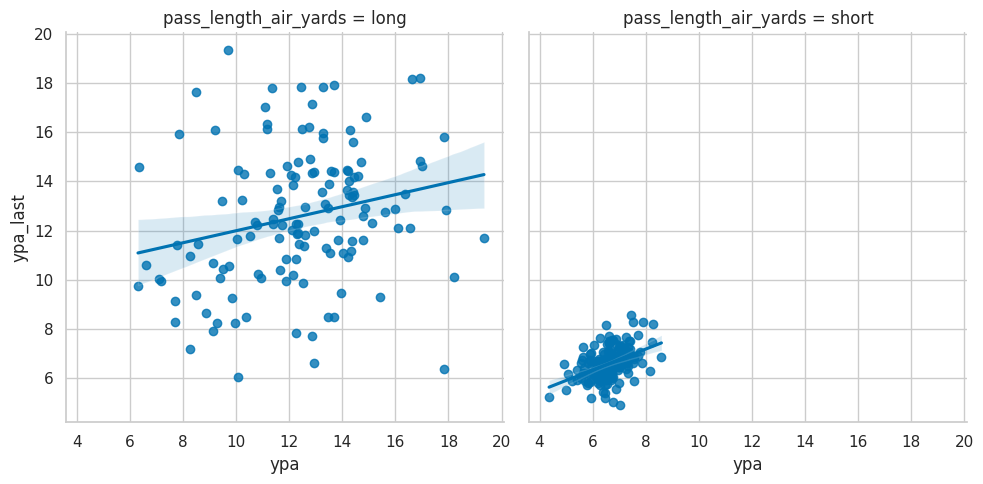

In [33]:
# Let's plot our data on a scatterplot.
sns.lmplot(data=pbp_py_p_s_pl,
           x='ypa',
           y='ypa_last',
           col='pass_length_air_yards');
plt.show();

In [34]:
# We can see the correlation using pandas as well.
pbp_py_p_s_pl\
  .query('ypa.notnull() & ypa_last.notnull()')\
  .groupby('pass_length_air_yards')[['ypa', 'ypa_last']]\
  .corr()

ypa  ypa_last
pass_length_air_yards                             
long                  ypa       1.000000  0.233890
                      ypa_last  0.233890  1.000000
short                 ypa       1.000000  0.438479
                      ypa_last  0.438479  1.000000

In [35]:
# From this we can understand that long passes have larger variance in ypa.
# Short passes are much more consistent across seasons.
# Let's take a look at 2017 leaders in ypa.
pbp_py_p_s_pl\
  .query(
      'pass_length_air_yards == "long" & season == 2017'
      )[['passer_id', 'passer', 'ypa']]\
  .sort_values(['ypa'], ascending=False)\
  .head(10)

,passer_id,passer,ypa
41,00-0023436,A.Smith,19.338236
79,00-0026498,M.Stafford,17.830769
12,00-0020531,D.Brees,16.632353
191,00-0032950,C.Wentz,13.555555
33,00-0022942,P.Rivers,13.347826
0,00-0019596,T.Brady,13.264706
129,00-0029604,K.Cousins,12.847458
114,00-0029263,R.Wilson,12.738636
203,00-0033077,D.Prescott,12.585366
109,00-0028986,C.Keenum,11.904762


In [36]:
# Now we can check 2018.
pbp_py_p_s_pl\
  .query(
      'pass_length_air_yards == "long" & season == 2018'
      )[['passer_id', 'passer', 'ypa']]\
  .sort_values(['ypa'], ascending=False)\
  .head(10)

,passer_id,passer,ypa
116,00-0029263,R.Wilson,15.597403
14,00-0020531,D.Brees,14.903226
205,00-0033077,D.Prescott,14.771930
214,00-0033106,J.Goff,14.445946
35,00-0022942,P.Rivers,14.357142
157,00-0031280,D.Carr,14.339286
188,00-0032268,M.Mariota,13.941176
64,00-0026143,M.Ryan,13.465754
193,00-0032950,C.Wentz,13.222222
24,00-0022803,E.Manning,12.941176
